# Spam/Fraud Message Detection with TF-IDF + Interpretable Linear Model

**Features:**
* Clean reproducible pipeline
* Proper evaluation (precision/recall/F1, ROC-AUC, PR-AUC)
* Threshold tuning for “fraud triage” style (optimize recall at acceptable precision)
* Interpretability: top spam indicators (feature weights)
* Error analysis: show false positives/negatives

In [7]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_recall_curve
)

## Load + clean data (robust)

In [ ]:
dataset = Path(Path.cwd()).resolve().parents[1] / "introduction" / "datasets" / "spam.csv"

raw = pd.read_csv(dataset, encoding="latin1")

label_col = "v1" if "v1" in raw.columns else raw.columns[0]
text_col  = "v2" if "v2" in raw.columns else raw.columns[1]

df = raw[[label_col, text_col]].rename(columns={label_col: "label", text_col: "text"}).copy()
df["text"] = df["text"].astype(str).fillna("")

df["y"] = (df["label"].str.lower().str.strip() != "ham").astype(int)
df = df.drop(columns=["label"])

df.head()


,text,y
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


### Dataset Checks


In [9]:
df["y"].value_counts(normalize=True).rename({0:"ham", 1:"spam"}).to_frame("proportion")


,proportion
y,
ham,0.865937
spam,0.134063


### Feature engineering

In [10]:
_url_re = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)

def make_numeric_features(text_series: pd.Series) -> pd.DataFrame:
    s = text_series.fillna("").astype(str)

    length = s.str.len()
    num_digits = s.str.count(r"\d")
    num_exclam = s.str.count(r"!")
    num_qmark  = s.str.count(r"\?")
    num_upper  = s.apply(lambda x: sum(1 for c in x if c.isupper()))
    has_url    = s.apply(lambda x: 1 if _url_re.search(x) else 0)

    pct_digits = np.where(length > 0, (num_digits / length) * 100.0, 0.0)
    pct_upper  = np.where(length > 0, (num_upper / length) * 100.0, 0.0)

    return pd.DataFrame({
        "len": length,
        "pct_digits": pct_digits,
        "pct_upper": pct_upper,
        "exclam": num_exclam,
        "qmark": num_qmark,
        "has_url": has_url,
    })

numeric_transformer = Pipeline(steps=[
    ("feats", FunctionTransformer(lambda X: make_numeric_features(X["text"]), validate=False)),
])


### Plot

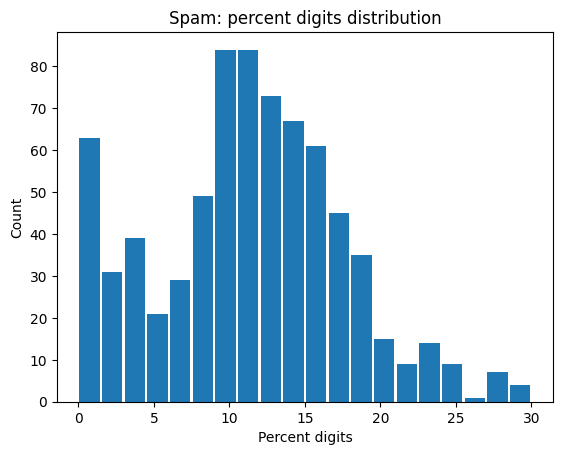

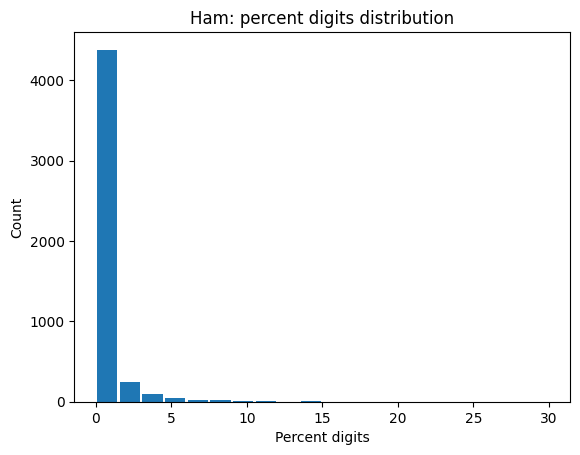

In [11]:
tmp = make_numeric_features(df["text"])
tmp["y"] = df["y"].values

plt.hist(tmp[tmp["y"] == 1]["pct_digits"], bins=20, range=(0, 30), rwidth=0.9)
plt.xlabel("Percent digits")
plt.ylabel("Count")
plt.title("Spam: percent digits distribution")
plt.show()

plt.hist(tmp[tmp["y"] == 0]["pct_digits"], bins=20, range=(0, 30), rwidth=0.9)
plt.xlabel("Percent digits")
plt.ylabel("Count")
plt.title("Ham: percent digits distribution")
plt.show()


Use TF-IDF + Logistic Regression. Add ngrams and mild regularization.

In [12]:
text_transformer = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
)

preprocess = ColumnTransformer(
    transformers=[
        ("text", text_transformer, "text"),
        ("num", numeric_transformer, ["text"]),
    ],
    remainder="drop",
)

clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",   # typically helps for spam imbalance
    n_jobs=None,
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", clf),
])


### Train/test split + metrics

In [13]:
X = df[["text"]]
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print(classification_report(y_test, pred, target_names=["ham", "spam"]))
print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC:", average_precision_score(y_test, proba))

cm = confusion_matrix(y_test, pred)
cm


              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       966
        spam       0.85      0.94      0.89       149

    accuracy                           0.97      1115
   macro avg       0.92      0.96      0.94      1115
weighted avg       0.97      0.97      0.97      1115

ROC-AUC: 0.9890783275668015
PR-AUC: 0.9185743584856519


array([[942,  24],
       [  9, 140]])

### Threshold tuning

In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, proba)

# Example policy: choose threshold with recall >= 0.95 and highest precision
target_recall = 0.95
valid = np.where(recall[:-1] >= target_recall)[0]  # recall has one extra element
if len(valid) > 0:
    best_idx = valid[np.argmax(precision[valid])]
    best_thr = thresholds[best_idx]
else:
    best_idx = np.argmax(2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12))
    best_thr = thresholds[best_idx]

best_thr


0.31698447899357535

In [20]:
pred_tuned = (proba >= best_thr).astype(int)
print("Threshold:", best_thr)
print(classification_report(y_test, pred_tuned, target_names=["ham", "spam"]))
confusion_matrix(y_test, pred_tuned)


Threshold: 0.31698447899357535
              precision    recall  f1-score   support

         ham       0.99      0.96      0.98       966
        spam       0.79      0.95      0.86       149

    accuracy                           0.96      1115
   macro avg       0.89      0.96      0.92      1115
weighted avg       0.97      0.96      0.96      1115



array([[928,  38],
       [  7, 142]])

In [21]:

prep = model.named_steps["prep"]
text_vec = prep.named_transformers_["text"]
text_features = text_vec.get_feature_names_out()

num_features = ["len", "pct_digits", "pct_upper", "exclam", "qmark", "has_url"]
all_features = np.concatenate([text_features, num_features])

coef = model.named_steps["clf"].coef_[0]
top_spam = np.argsort(coef)[-25:][::-1]
top_ham  = np.argsort(coef)[:25]

pd.DataFrame({"feature": all_features[top_spam], "weight": coef[top_spam]}).head(25)


,feature,weight
0,has_url,3.205464
1,free,2.946312
2,your,2.745589
3,text,2.457975
4,reply,2.375370
5,mobile,2.083379
6,sms,1.923724
7,service,1.792006
8,ringtone,1.789351
9,to,1.788940


In [22]:
pd.DataFrame({"feature": all_features[top_ham], "weight": coef[top_ham]}).head(25)


,feature,weight
0,my,-1.821296
1,at,-1.420326
2,gt,-1.401006
3,lt,-1.389677
4,lt gt,-1.314390
5,that,-1.213308
6,me,-1.212499
7,but,-1.135733
8,got,-0.885674
9,hey,-0.864160


In [23]:
test = X_test.copy()
test["y_true"] = y_test.values
test["proba"] = proba
test["y_pred"] = pred_tuned

false_pos = test[(test["y_true"] == 0) & (test["y_pred"] == 1)].sort_values("proba", ascending=False)
false_neg = test[(test["y_true"] == 1) & (test["y_pred"] == 0)].sort_values("proba", ascending=True)

false_pos.head(10)


,text,y_true,proba,y_pred
1611,645,0,1.000000,1
5173,U 2.,0,0.999973,1
262,MY NO. IN LUTON 0125698789 RING ME IF UR AROUN...,0,0.999366,1
3811,Yep then is fine 7.30 or 8.30 for ice age.,0,0.991648,1
2618,Hey pple...$700 or $900 for 5 nights...Excelle...,0,0.924351,1
2157,Sad story of a Man - Last week was my b'day. M...,0,0.923071,1
449,10 min later k...,0,0.921159,1
4266,SORRY IM STIL FUCKED AFTER LAST NITE WENT TOBE...,0,0.833934,1
4139,Leave it wif me lar... ÌÏ wan to carry meh so ...,0,0.800818,1
1670,Lmao!nice 1,0,0.783676,1
